# PSF projection and deprojection
In this notebook we illustrate the equivalence between the PSF CDP values in cube space and the 2D projected PSF values.

In [1]:
import funcs

import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
%matplotlib notebook

import warnings
warnings.simplefilter('ignore')

In [2]:
# 1-Define the paths to the data
workDir = '/Users/ioannisa/Desktop/python/miri_devel/'
cdpDir  = workDir+'cdp_data/'
d2cMapDir = workDir+'notebooks/distortionMaps/'

# 3-load the MRS distortion maps, they are used extensively in a multitude of python functions relating to the analysis of MRS data
band     = '1A' # this is the spectral band (side of the slope image) to be analyzed
d2cMaps   = funcs.load_obj('d2cMaps_band'+band+'_tr80pc',path=d2cMapDir) # here, d2c stands for detector to cube transformation, from x,y integer pixel coordinates, to alpha, beta (or RA and DEC), and wavelength coordinates
det_dims = (1024,1032) # placeholder for the dimension of the detector

psffits,specres_table = funcs.get_cdps(band,cdpDir)[3:5]

In [4]:
lambcens,lambfwhms = funcs.spectral_gridding(band,d2cMaps,specres_table=specres_table)
print('There are {} spectral bins in band {}.'.format(len(lambcens),band))

There are 599 spectral bins in band 1A


<IPython.core.display.Javascript object>


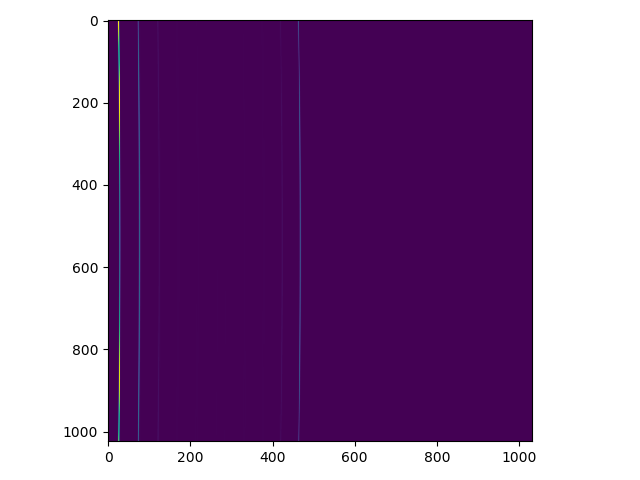

In [4]:
source_alpha_center = 0.
source_beta_center  = 0.

psf = funcs.evaluate_psf_cdp(psffits,d2cMaps,source_center=[source_alpha_center,source_beta_center])

plt.figure()
plt.imshow(psf)
plt.tight_layout()

<IPython.core.display.Javascript object>


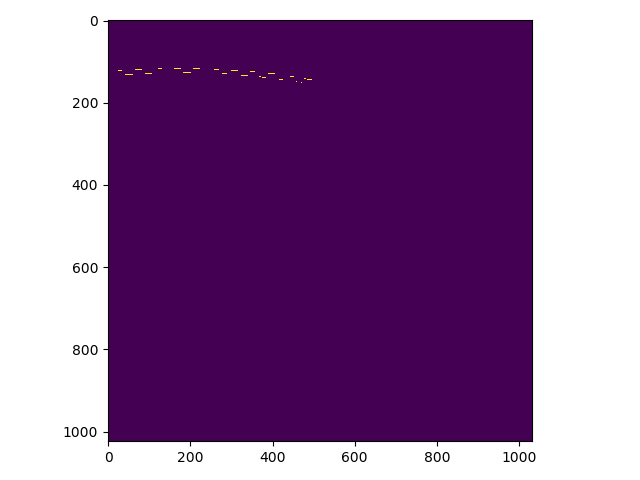

In [5]:
# Example
psf_copy = psf.copy()
radii = np.arange(0,4+funcs.mrs_aux(band)[5]/2.,funcs.mrs_aux(band)[5]/2.)

ibin1 = 100
pixelsInBin = np.where((np.abs(d2cMaps['lambdaMap']-lambcens[ibin1])<lambfwhms[ibin1]/2.))
BinMask = np.zeros(det_dims); BinMask[pixelsInBin] = 1.
encircled_energy_fraction_1 = np.zeros(len(radii))
for i,radius in enumerate(radii):
    pix_in_aperture,aperture_area = funcs.elliptical_aperture(center=[source_alpha_center,source_beta_center],r=radius,q=1.,pa=0.,d2cMaps=d2cMaps)
    ApertureMask = np.zeros(det_dims); ApertureMask[pix_in_aperture] = 1.
    psf_copy_BinMasked = psf_copy*BinMask
    psf_copy_BinMasked_AperMasked = psf_copy*BinMask*ApertureMask

    encircled_energy_fraction_1[i] = psf_copy_BinMasked_AperMasked.sum()/psf_copy_BinMasked.sum()
    
plt.figure()
plt.imshow(BinMask)
plt.tight_layout()

ibin2 = 200
pixelsInBinNoNaN = np.where((np.abs(d2cMaps['lambdaMap']-lambcens[ibin2])<lambfwhms[ibin2]/2.))
BinMask = np.zeros(det_dims); BinMask[pixelsInBinNoNaN] = 1.
encircled_energy_fraction_2 = np.zeros(len(radii))
for i,radius in enumerate(radii):
    pix_in_aperture,aperture_area = funcs.elliptical_aperture(center=[source_alpha_center,source_beta_center],r=radius,q=1.,pa=0.,d2cMaps=d2cMaps)
    ApertureMask = np.zeros(det_dims); ApertureMask[pix_in_aperture] = 1.
    psf_copy_BinMasked = psf_copy*BinMask
    psf_copy_BinMasked_AperMasked = psf_copy*BinMask*ApertureMask

    encircled_energy_fraction_2[i] = psf_copy_BinMasked_AperMasked.sum()/psf_copy_BinMasked.sum()

<IPython.core.display.Javascript object>


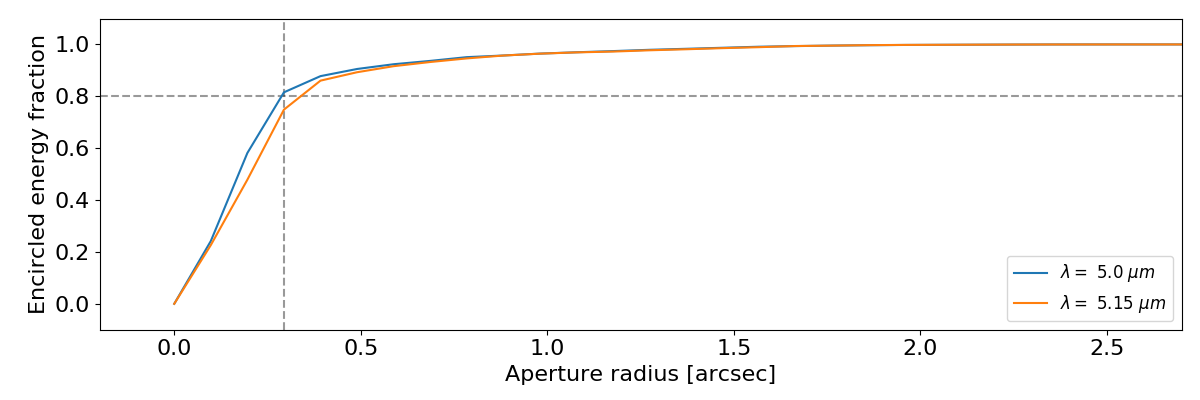

Encircled energy fraction of 80% at radius of 0.29 arcsec


In [6]:
EightyPercentFractionRadius = radii[funcs.find_nearest(np.array(encircled_energy_fraction_1),0.8)]
plt.figure(figsize=(12,4))
plt.plot(radii,encircled_energy_fraction_1,label=r'$\lambda =$ {} $\mu m$'.format(round(lambcens[ibin1],2) ))
plt.plot(radii,encircled_energy_fraction_2,label=r'$\lambda =$ {} $\mu m$'.format(round(lambcens[ibin2],2) ))
plt.vlines(EightyPercentFractionRadius,-0.1,1.1,linestyle='dashed',alpha=0.4)
plt.hlines(0.8,-0.2,2.7,linestyle='dashed',alpha=0.4)
plt.xlim(-0.2,2.7)
plt.ylim(-0.1,1.1)
plt.xlabel('Aperture radius [arcsec]',fontsize=16)
plt.ylabel('Encircled energy fraction',fontsize=16)
plt.legend(loc='lower right',fontsize=12)
plt.tick_params(axis='both',labelsize=16)
plt.tight_layout()

print('Encircled energy fraction of 80% at radius of {} arcsec'.format(round(EightyPercentFractionRadius,2)))

In [13]:
psf_copy = psf.copy()
radii = np.arange(0,4+funcs.mrs_aux(band)[5]/2.,funcs.mrs_aux(band)[5]/2.)

encircled_energy_fractions = [[] for i in range(len(lambcens))]
for ibin in range(len(lambcens)):
    if ibin%100 == 0: print 'Bin {}'.format(ibin)
    pixelsInBinNoNaN = np.where((np.abs(d2cMaps['lambdaMap']-lambcens[ibin])<lambfwhms[ibin]/2.))
    BinMask = np.zeros(det_dims); BinMask[pixelsInBinNoNaN] = 1.
    encircled_energy_fractions[ibin] = np.zeros(len(radii))
    for i,radius in enumerate(radii):
        pix_in_aperture,aperture_area = funcs.elliptical_aperture(center=[source_alpha_center,source_beta_center],r=radius,q=1.,pa=0.,d2cMaps=d2cMaps)
        ApertureMask = np.zeros(det_dims); ApertureMask[pix_in_aperture] = 1.
        psf_copy_BinMasked = psf_copy*BinMask
        psf_copy_BinMasked_AperMasked = psf_copy*BinMask*ApertureMask

        encircled_energy_fractions[ibin][i] = psf_copy_BinMasked_AperMasked.sum()/psf_copy_BinMasked.sum()
funcs.save_obj(encircled_energy_fractions,'encircled_energy_fractions_band'+band)

Bin 0
Bin 100
Bin 200
Bin 300
Bin 400
Bin 500


<IPython.core.display.Javascript object>


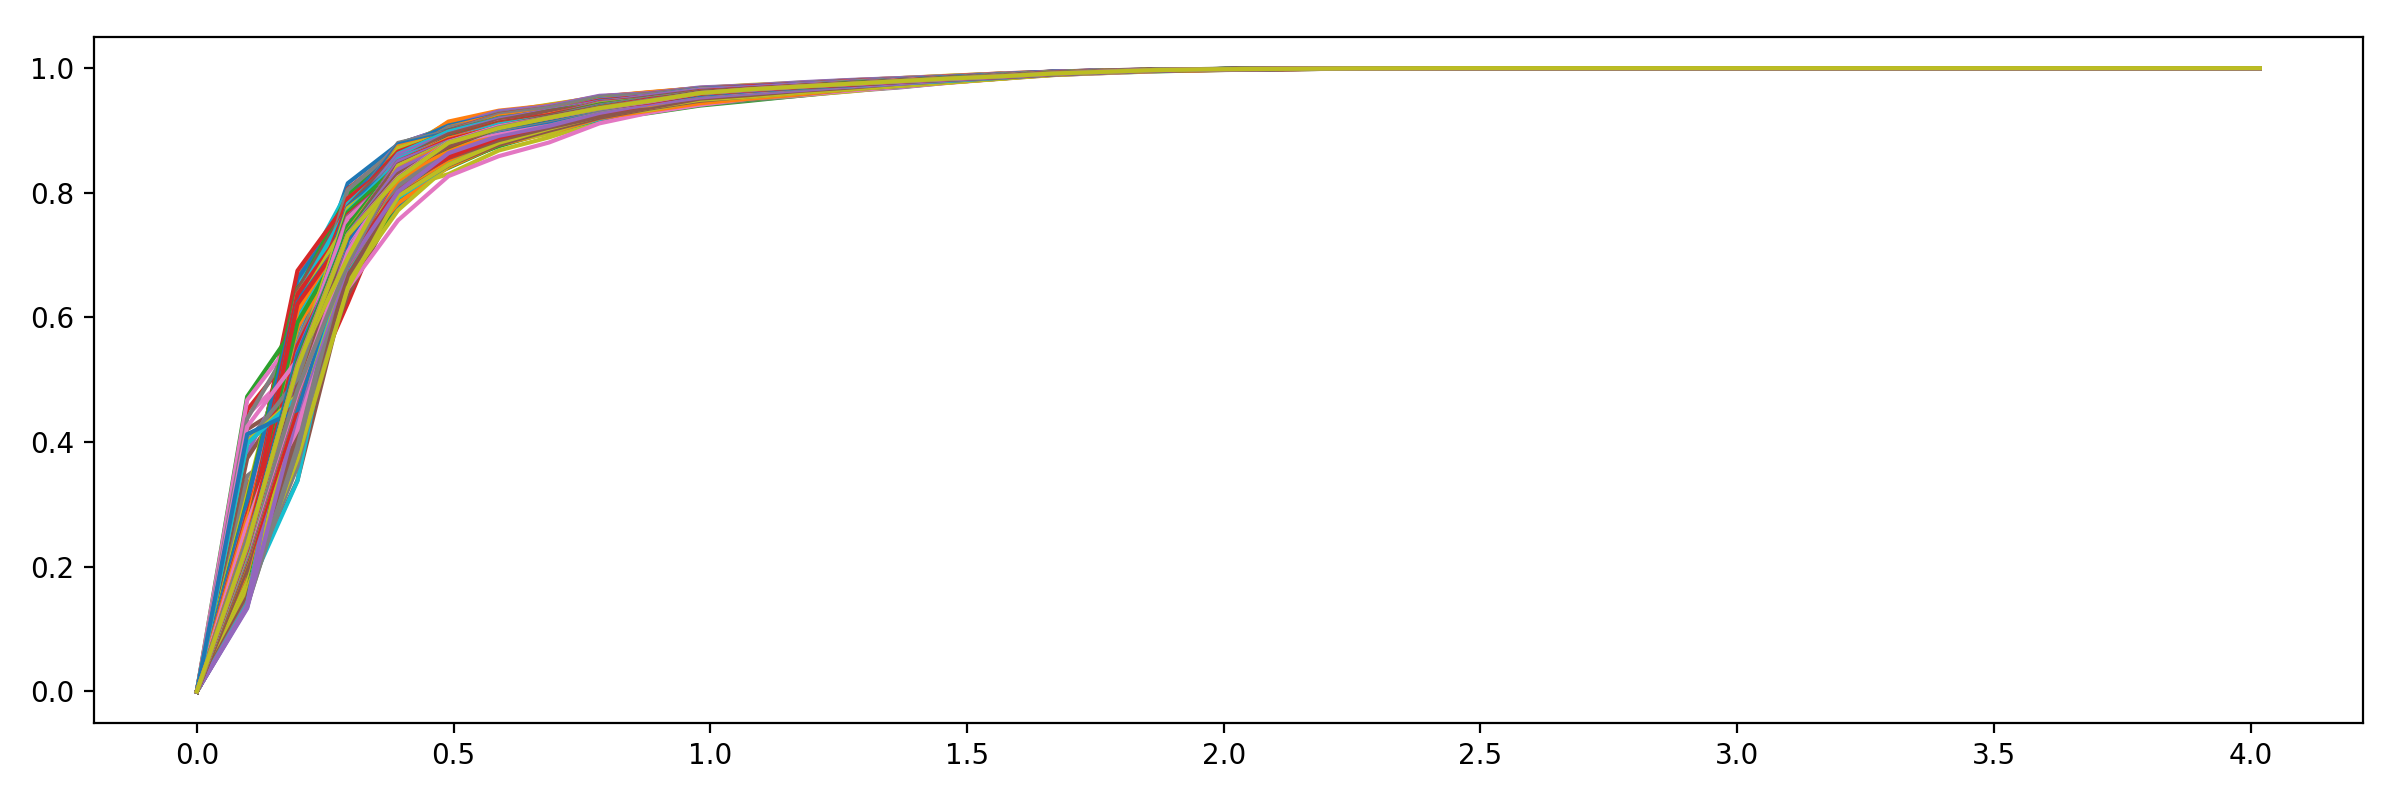

In [20]:
plt.figure(figsize=(12,4))
for ibin in range(100,len(lambcens)-100):
    plt.plot(radii,encircled_energy_fractions[ibin])
plt.tight_layout()

In [16]:
bands = ['1A','1B','1C','2A','2B','2C','3A','3B','3C','4A','4B','4C']
encircled_energy_fraction_dic = {}
for band in bands:
    encircled_energy_fraction_dic[band] = funcs.load_obj('encircled_energy_fractions_band'+band)
wavelengths_dic = funcs.load_obj('spec_grid_wavelengths')

In [18]:
import scipy.interpolate as scp_interpolate

eighty_percent = {}
for band in bands:
    radii = np.arange(0,4+funcs.mrs_aux(band)[5]/2.,funcs.mrs_aux(band)[5]/2.)
    test = []
    for ibin in range(30,len(wavelengths_dic[band])-30):
        test.append(scp_interpolate.interp1d(encircled_energy_fraction_dic[band][ibin],radii)(0.8))
    eighty_percent[band] = np.array(test)
funcs.save_obj(eighty_percent,'eighty_percent_encircled_energy_fraction')
    
from scipy.optimize import curve_fit
plt.figure(figsize=(12,4))
for band in bands:
    plt.plot(wavelengths_dic[band][30:len(wavelengths_dic[band])-30],eighty_percent[band])
    popt,pcov = curve_fit(funcs.straight_line,wavelengths_dic[band][30:len(wavelengths_dic[band])-30],eighty_percent[band])
    plt.plot(wavelengths_dic[band][30:len(wavelengths_dic[band])-30],funcs.straight_line(wavelengths_dic[band][30:len(wavelengths_dic[band])-30],*popt),'k',linestyle='dashed')
plt.xlim(4.4,28.4)
plt.xticks(np.arange(4,30,2))
plt.xlabel('Wavelength [micron]',fontsize=16)
plt.ylabel('Aperture radius [arcsec]',fontsize=16)
plt.tick_params(axis='both',labelsize=16)
plt.tight_layout()

ValueError: A value in x_new is above the interpolation range.

[ 0.          0.23378312  0.49420581  0.74108208  0.85778183  0.88908765
  0.9129353   0.9293837   0.94193568  0.95300966  0.96007565  0.96533851
  0.9692255   0.97410857  0.97794134  0.98197704  0.98506583  0.98971211
  0.99204568  0.99427525  0.99544018  0.99706289  0.99777703  0.99901264
  0.99924488  0.99973733  0.99987451  0.99995002  1.          1.          1.
  1.          1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.        ]


<IPython.core.display.Javascript object>


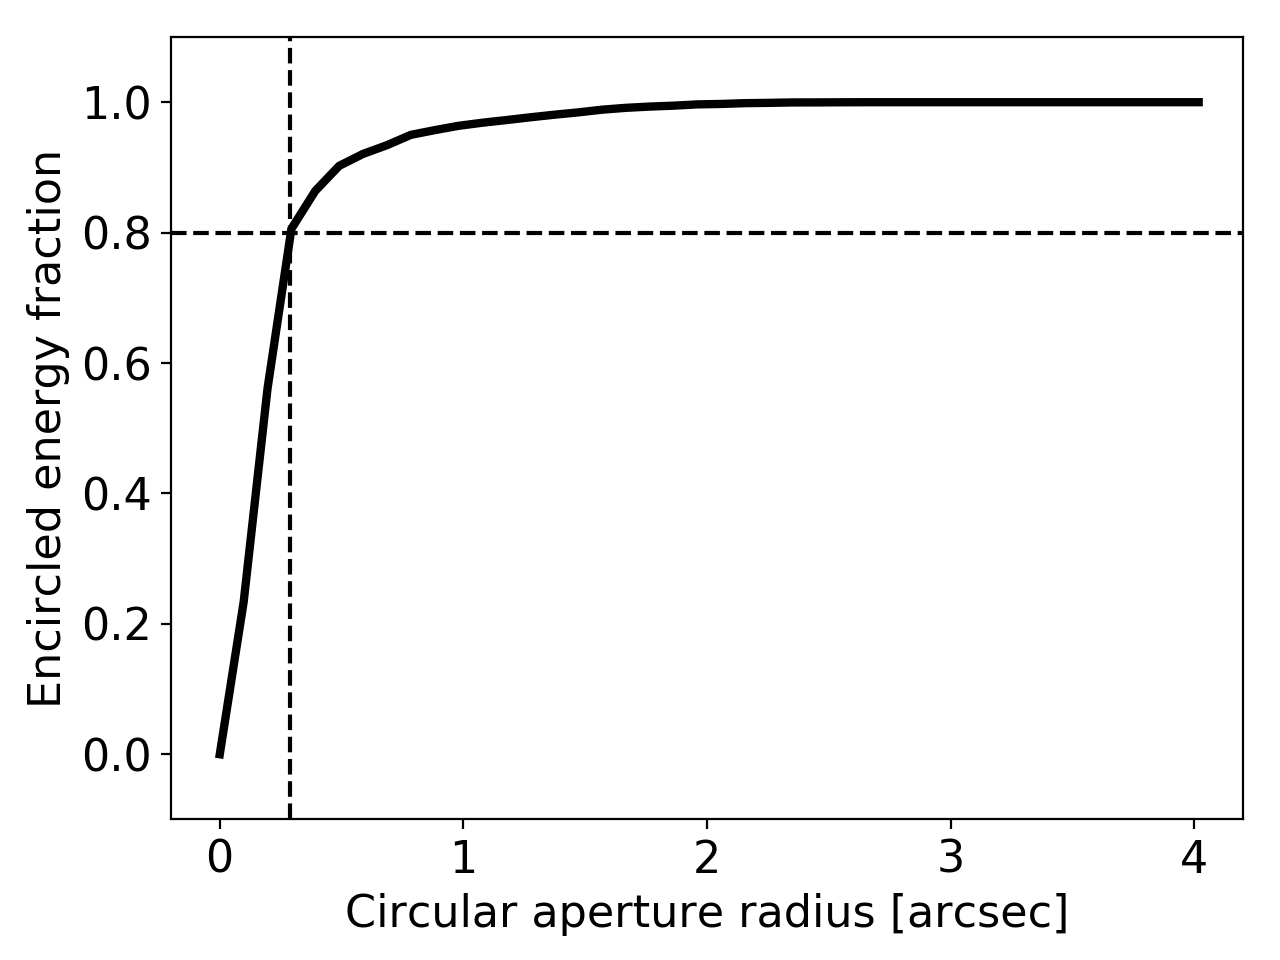

In [39]:
band = '1A'
ibin = 200
print encircled_energy_fraction_dic[band][ibin]
radii = np.arange(0,4+maux.MRS_alphapix[band[0]]/2.,maux.MRS_alphapix[band[0]]/2.)

plt.figure()
for ibin in [100]:
    plt.plot(radii,encircled_energy_fraction_dic[band][ibin],'k',linewidth=3)
plt.hlines(0.8,-0.2,4.2,linestyle='dashed')
plt.vlines(0.29,-0.1,1.1,linestyle='dashed')
plt.xlim(-0.2,4.2)
plt.ylim(-0.1,1.1)
plt.xlabel('Circular aperture radius [arcsec]',fontsize=16)
plt.ylabel('Encircled energy fraction',fontsize=16)
plt.tick_params(axis='both',labelsize=16)
plt.tight_layout()

# plt.figure()
# for ibin in range(100,200):
#     plt.plot(radii,1-encircled_energy_fraction_dic[band][ibin])